In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
users = pd.read_csv("users.csv")
items = pd.read_csv("items.csv")
interactions = pd.read_csv("interactions.csv")

# Convert timestamp column to datetime format
interactions["timestamp"] = pd.to_datetime(interactions["timestamp"])
users.head()


,user_id,role,skill_level,profile_score
0,FAN_100000,Coach,Beginner,0.78
1,FAN_100001,Medic,Level_1,0.39
2,FAN_100002,Coach,Beginner,0.68
3,FAN_100003,Coach,Beginner,0.36
4,FAN_100004,Medic,Beginner,0.66


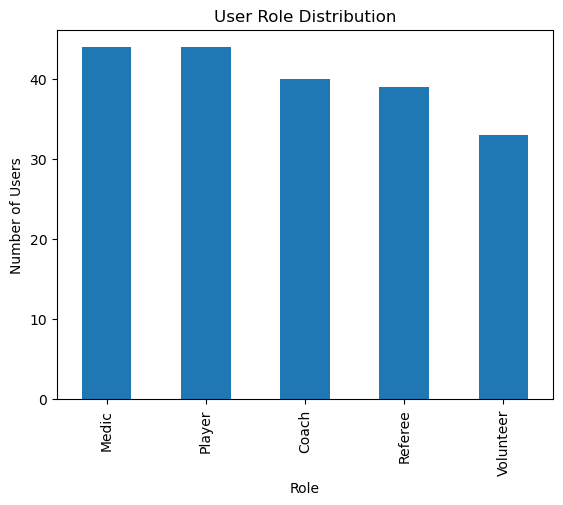

In [10]:
users["role"].value_counts().plot(
    kind="bar",
    title="User Role Distribution"
)
plt.xlabel("Role")
plt.ylabel("Number of Users")
plt.show()


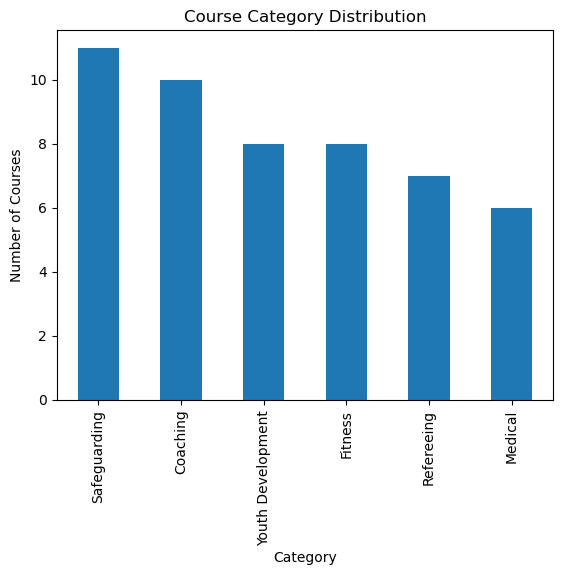

In [11]:
items["category"].value_counts().plot(
    kind="bar",
    title="Course Category Distribution"
)
plt.xlabel("Category")
plt.ylabel("Number of Courses")
plt.show()


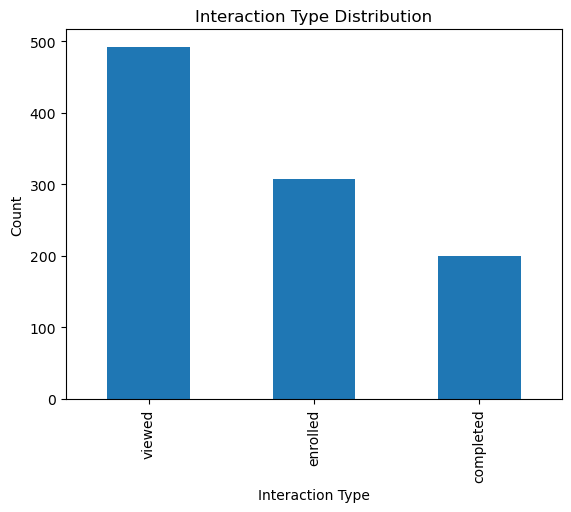

In [12]:
interactions["interaction"].value_counts().plot(
    kind="bar",
    title="Interaction Type Distribution"
)
plt.xlabel("Interaction Type")
plt.ylabel("Count")
plt.show()


In [ ]:
def get_similar_users(target_user_id, users_df):
    """
    Returns a list of users who have the same role
    and skill level as the target user.
    """

    # Get target user's profile
    target_user = users_df[users_df["user_id"] == target_user_id].iloc[0]

    # Filter users with same role and skill level
    similar_users = users_df[
        (users_df["role"] == target_user["role"]) &
        (users_df["skill_level"] == target_user["skill_level"])
    ]["user_id"].tolist()

    return similar_users

#Prevents recommending medic/referee courses to coaches

In [7]:
# Create a matrix:
# Rows   → users
# Columns → courses/programs
# Values → interaction weight (view=1, enroll=3, complete=5)

user_item_matrix = interactions.pivot_table(
    index="user_id",
    columns="item_id",
    values="weight",
    aggfunc="sum",
    fill_value=0
)


In [46]:
user_item_matrix.head()

item_id,C_2000,C_2001,C_2002,C_2003,C_2004,C_2005,C_2006,C_2007,C_2008,C_2009,...,C_2040,C_2041,C_2042,C_2043,C_2044,C_2045,C_2046,C_2047,C_2048,C_2049
user_id,,,,,,,,,,,,,,,,,,,,,
FAN_100000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
FAN_100001,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
FAN_100002,0,0,0,0,0,0,0,5,0,0,...,0,0,1,5,0,0,0,0,0,0
FAN_100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
FAN_100004,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,3,0,0,0,0,0


In [15]:
item_item_matrix = user_item_matrix.T.dot(user_item_matrix)
np.fill_diagonal(item_item_matrix.values, 0)


In [ ]:
item_item_matrix.head()
#Flipped from user*item to item*item: why? 

item_id,C_2000,C_2001,C_2002,C_2003,C_2004,C_2005,C_2006,C_2007,C_2008,C_2009,...,C_2040,C_2041,C_2042,C_2043,C_2044,C_2045,C_2046,C_2047,C_2048,C_2049
item_id,,,,,,,,,,,,,,,,,,,,,
C_2000,0,0,0,23,3,0,16,15,12,3,...,1,1,3,3,9,4,15,4,1,0
C_2001,0,0,14,2,20,23,11,21,15,7,...,3,16,41,15,16,4,0,32,0,14
C_2002,0,14,0,17,18,8,39,21,0,29,...,15,5,22,0,0,5,18,9,54,23
C_2003,23,2,17,0,3,5,15,9,0,3,...,15,25,3,6,7,15,9,1,7,2
C_2004,3,20,18,3,0,3,23,0,44,15,...,23,9,25,6,1,0,34,12,3,0


High value means:

“These two courses are often taken together”

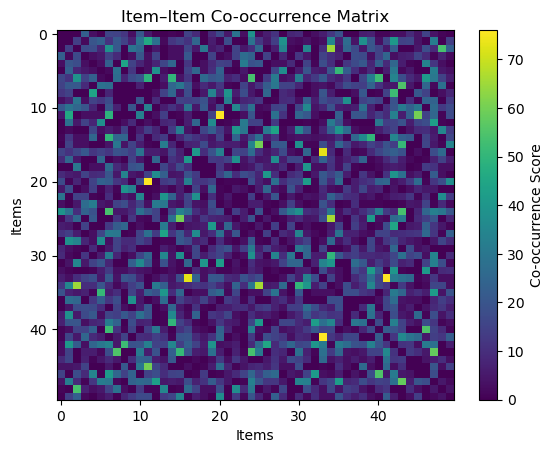

In [16]:
plt.imshow(item_item_matrix.values, aspect="auto")
plt.title("Item–Item Co-occurrence Matrix")
plt.xlabel("Items")
plt.ylabel("Items")
plt.colorbar(label="Co-occurrence Score")
plt.show()


In [ ]:
def recommend_items(user_id, top_k=5):
    # Step 1: Find users similar to the target user (same role & skill level)
    similar_users = get_similar_users(user_id, users)

    # Step 2: Filter the user-item matrix to only include rows of similar users
    filtered_matrix = user_item_matrix.loc[
        user_item_matrix.index.intersection(similar_users)
    ]

    # Step 3: Get the target user's row (vector of items they interacted with)
    user_vector = filtered_matrix.loc[user_id]

    # Step 4: Identify items the user has already interacted with
    # (values > 0 mean some interaction, e.g., rating, click, purchase)
    interacted_items = user_vector[user_vector > 0].index.tolist()

    # Step 5: Initialize an empty Series to store recommendation scores
    scores = pd.Series(dtype=float)

    # Step 6: For each item the user interacted with,
    # add similarity scores from the item-item matrix
    # (this aggregates recommendations based on similar items)
    for item in interacted_items:
        scores = scores.add(item_item_matrix[item], fill_value=0)

    # Step 7: Remove items the user has already interacted with
    # we don’t want to recommend things they already consumed
    scores = scores.drop(interacted_items, errors="ignore")

    # Step 8: Sort items by score (highest first) and return top_k recommendations
    return scores.sort_values(ascending=False).head(top_k)




Quick Explanation of Key Concepts
- user_item_matrix: A matrix where rows = users, columns = items, values = interactions (like ratings or clicks).
- item_item_matrix: A matrix of item-to-item similarity (e.g., cosine similarity, correlation).
- intersection: Ensures we only keep rows that match the similar users.
- scores.add(...): Adds similarity scores across items the user interacted with.
- drop(interacted_items): Prevents recommending items the user already knows.
- sort_values(...).head(top_k): Picks the top k items with the highest recommendation scores.

Summary:
This function recommends items to a user by looking at what similar users interacted with, aggregating item-to-item similarity scores, and then returning the top k items the user hasn’t already consumed.


In [19]:
sample_user = users.sample(1)["user_id"].iloc[0]
recommendations = recommend_items(sample_user)

print("User:", sample_user)
print(recommendations)


User: FAN_100122
item_id
C_2035    118.0
C_2030    107.0
C_2014    100.0
C_2034    100.0
C_2027     97.0
dtype: float64


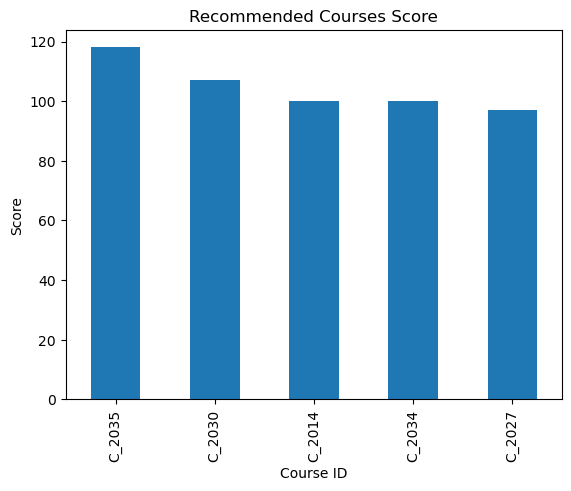

In [20]:
recommendations.plot(
    kind="bar",
    title="Recommended Courses Score"
)
plt.xlabel("Course ID")
plt.ylabel("Score")
plt.show()


In [21]:
# Sort interactions by time
interactions_sorted = interactions.sort_values("timestamp")

# Split ratio
train_ratio = 0.8

split_index = int(len(interactions_sorted) * train_ratio)

train_data = interactions_sorted.iloc[:split_index]
test_data = interactions_sorted.iloc[split_index:]

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)


Train size: (800, 5)
Test size: (200, 5)


Why time-based?
Because we predict future behavior from past behavior.

In [22]:
train_user_item = train_data.pivot_table(
    index="user_id",
    columns="item_id",
    values="weight",
    aggfunc="sum",
    fill_value=0
)


In [23]:
item_item_train = train_user_item.T.dot(train_user_item)

# Remove self similarity
np.fill_diagonal(item_item_train.values, 0)


This is “trained model”
(no gradients, no epochs — math-based learning).

In [24]:
def recommend_items_train(user_id, top_k=5):
    # Skip users not in training set
    if user_id not in train_user_item.index:
        return []

    user_vector = train_user_item.loc[user_id]
    interacted_items = user_vector[user_vector > 0].index.tolist()

    scores = pd.Series(dtype=float)

    for item in interacted_items:
        scores = scores.add(item_item_train[item], fill_value=0)

    scores = scores.drop(interacted_items, errors="ignore")
    return scores.sort_values(ascending=False).head(top_k).index.tolist()


In [25]:
def precision_at_k(recommended, relevant, k):
    if len(recommended) == 0:
        return 0.0

    recommended_k = recommended[:k]
    relevant_set = set(relevant)

    hits = sum(1 for item in recommended_k if item in relevant_set)
    return hits / k


In [26]:
def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0.0

    recommended_k = recommended[:k]
    relevant_set = set(relevant)

    hits = sum(1 for item in recommended_k if item in relevant_set)
    return hits / len(relevant_set)


In [27]:
K = 5
precisions = []
recalls = []

# Group test interactions by user
test_grouped = test_data.groupby("user_id")

for user_id, group in test_grouped:
    # Items user actually interacted with in test period
    relevant_items = group["item_id"].tolist()

    # Get model recommendations
    recommended_items = recommend_items_train(user_id, top_k=K)

    if len(recommended_items) == 0:
        continue

    precisions.append(
        precision_at_k(recommended_items, relevant_items, K)
    )

    recalls.append(
        recall_at_k(recommended_items, relevant_items, K)
    )

print("Average Precision@5:", np.mean(precisions))
print("Average Recall@5:", np.mean(recalls))


Average Precision@5: 0.02741935483870968
Average Recall@5: 0.07661290322580645


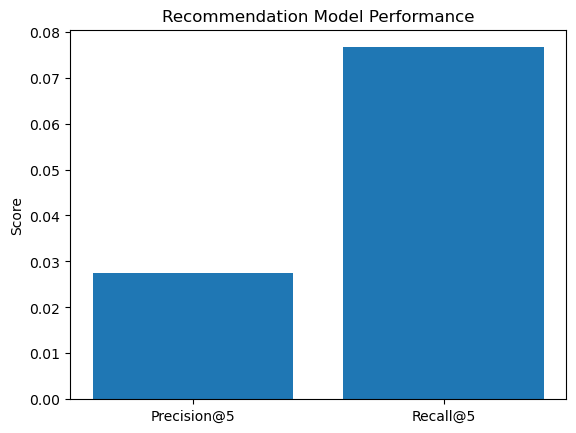

In [28]:
plt.bar(["Precision@5", "Recall@5"], 
        [np.mean(precisions), np.mean(recalls)])
plt.title("Recommendation Model Performance")
plt.ylabel("Score")
plt.show()


In [31]:
# Use only strong interactions
train_data_strong = train_data[
    train_data["interaction"].isin(["enrolled", "completed"])
]

# Course popularity based on strong signals
course_popularity = (
    train_data_strong
    .groupby("item_id")["weight"]
    .sum()
)


In [32]:
train_user_item = train_data_strong.pivot_table(
    index="user_id",
    columns="item_id",
    values="weight",
    aggfunc="sum",
    fill_value=0
)

item_item_train = train_user_item.T.dot(train_user_item)
np.fill_diagonal(item_item_train.values, 0)


In [33]:
def recommend_items_train(user_id, top_k=5):
    # Skip users not in training set
    if user_id not in train_user_item.index:
        return []

    # Items user has already interacted with
    user_vector = train_user_item.loc[user_id]
    interacted_items = user_vector[user_vector > 0].index.tolist()

    scores = pd.Series(dtype=float)

    # Item-item similarity scoring
    for item in interacted_items:
        scores = scores.add(item_item_train[item], fill_value=0)

    # 🔥 Popularity boost (THIS WAS THE ERROR PART)
    scores = scores.add(course_popularity, fill_value=0)

    # Remove already seen items
    scores = scores.drop(interacted_items, errors="ignore")

    return scores.sort_values(ascending=False).head(top_k).index.tolist()


In [34]:
K = 5
precisions = []
recalls = []

test_grouped = test_data.groupby("user_id")

for user_id, group in test_grouped:
    relevant_items = group["item_id"].tolist()
    recommended_items = recommend_items_train(user_id, top_k=K)

    if len(recommended_items) == 0:
        continue

    precisions.append(
        precision_at_k(recommended_items, relevant_items, K)
    )

    recalls.append(
        recall_at_k(recommended_items, relevant_items, K)
    )

print("Average Precision@5:", np.mean(precisions))
print("Average Recall@5:", np.mean(recalls))


Average Precision@5: 0.04403669724770642
Average Recall@5: 0.1337920489296636


In [37]:
from sklearn.decomposition import TruncatedSVD

In [38]:
# Use only strong signals
mf_data = interactions[
    interactions["interaction"].isin(["enrolled", "completed"])
]

# User–item matrix
user_item_mf = mf_data.pivot_table(
    index="user_id",
    columns="item_id",
    values="weight",
    aggfunc="sum",
    fill_value=0
)


In [39]:
# Number of latent factors
n_factors = 20

svd_model = TruncatedSVD(
    n_components=n_factors,
    random_state=42
)

# User latent matrix
user_embeddings = svd_model.fit_transform(user_item_mf)

# Item latent matrix
item_embeddings = svd_model.components_


In [40]:
def recommend_mf(user_id, top_k=5):
    if user_id not in user_item_mf.index:
        return []

    user_idx = user_item_mf.index.get_loc(user_id)

    # Compute scores via dot product
    scores = np.dot(
        user_embeddings[user_idx],
        item_embeddings
    )

    scores = pd.Series(
        scores,
        index=user_item_mf.columns
    )

    # Remove already interacted items
    interacted = user_item_mf.loc[user_id]
    scores = scores[interacted == 0]

    return scores.sort_values(ascending=False).head(top_k)


In [41]:
sample_user = user_item_mf.sample(1).index[0]

print("User:", sample_user)
print("MF Recommendations:")
print(recommend_mf(sample_user))


User: FAN_100078
MF Recommendations:
item_id
C_2017    0.877115
C_2009    0.811946
C_2001    0.738825
C_2045    0.618754
C_2010    0.591233
dtype: float64
